In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.simplefilter('ignore')

# 1. Basic look at the data set
In this part the dataset is loaded, and all the columns are briefly analysed.

## 1.1 Loading data frame
Loading dataframe, looking at the number of missing values and grouping the columns by type.

In [3]:
df_model = pd.read_csv('train.csv')
df_model['building_model'] = 1
df_sub = pd.read_csv('test.csv')
df_sub['building_model'] = 0
df = df_model.append(df_sub, sort=False).reset_index(
    drop=True)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,building_model
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


### 1.2 Looking at overall dataset
Checking for presence of NaN values in columns, number of rows and columns, types of data and number of unique values for all columns.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

NaN values present only in education columns, other than that the dataset seems to be clear. For this model, to fill the education NaN values imputation will take place.

In [6]:
df.education = df.education.fillna('SCH') # would prefer an alternative imputation to zero-imputation

In [7]:
for column in df.columns:
    print('Number of unique values in', column, '-', len(df[column].unique()))

Number of unique values in client_id - 110148
Number of unique values in app_date - 120
Number of unique values in education - 5
Number of unique values in sex - 2
Number of unique values in age - 52
Number of unique values in car - 2
Number of unique values in car_type - 2
Number of unique values in decline_app_cnt - 24
Number of unique values in good_work - 2
Number of unique values in score_bki - 102618
Number of unique values in bki_request_cnt - 40
Number of unique values in region_rating - 7
Number of unique values in home_address - 3
Number of unique values in work_address - 3
Number of unique values in income - 1207
Number of unique values in sna - 4
Number of unique values in first_time - 4
Number of unique values in foreign_passport - 2
Number of unique values in default - 3
Number of unique values in building_model - 2


1. client_id - id if a client, should not affect the model, pseudo-numerical column;
2. app_date - date of application, string that needs to be converted to datetime;
3. education - which level of education the client has, categorical;
4. sex - sex of a client, binary categorical;
5. car - does client have a car, binary categorical;
6. car_type - does client have an imported car, binary categorical;
7. decline_app_cnt - number of times when loan was rejected, numberical;
8. good_work - if a client has a job that is considered "good" by bank standarts, binary categorical;
9. score_bki - credit score of a client, numerical;
10. bki_request_cnt - number of requests to national bureau of credit histories, numerical;
11. region_rating - rating of a region, categorical;
12. home_address - category of home adress of a client, categorical;
13. work_address - category of work adress of a client, categorical;
14. income - income of a client, numerical;
15. sna - is client connected to another client of a bank, binary categorical;
16. first_time - how fresh is the information about the client, category;
17. foreign_passport - does client have a traveling passport, categorical binary;
18. default - has client ever defaulted before, categorical binary.

Based on these oservations 3 lists are made, containing numerical, categorical and binary columns:

In [8]:
binary = ['sex', 'car', 'car_type', 'good_work',
          'foreign_passport']
category = ['education', 'work_address', 'home_address',
            'sna', 'first_time']
numerical = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'region_rating','score_bki']
all_categories = category + binary + ['default']

## 1.3 Visualisation of data
Plotting different types of graphs for columns, brielfly describing the distribution of data.

In [9]:
def category_barplot(column):
    # the function takes in the string that is the
    # column and plots a countplot to visualise
    # the disctibution of classes
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.countplot(x = column,
                  data = df,
                  hue='default')
    plt.xticks(rotation=45)
    ax.set_title('Barplot for ' + column)
    plt.show()


def numerical_histplot(column):
    # the function takes in a string that is the
    # column and plots a histplot for it
    fig, ax = plt.subplots(figsize=(15, 10))
    sns.countplot(df[column])
    ax.set_title('Histplot for ' + column)
    plt.show()


def normalised_histplot(column):
    # the function takes in a string that is the
    # column and plots a histplot for it
    plt.figure()
    sns.distplot(df[column], kde = False, rug=False)
    plt.title(column)
    plt.show()

    
def boxplot_numerical(column):
    # the function takes in a string that is the
    # column and plots a box for it
    fig, ax = plt.subplots(figsize=(10, 15))
    sns.boxplot(x = 'default',
                y = column,
                data = df)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

    
def clear_boxplot(column):
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.boxplot(x = column,
                data = df)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()
    

def metrics(y_val, y_pred):
    cm = confusion_matrix(y_val, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
    cmd.plot()
    cmd.ax_.set(xlabel='Predicted', ylabel='True')
    
    print('accuracy_score:',accuracy_score(y_val,y_pred))
    print('precision_score:',precision_score(y_val,y_pred))
    print('recall_score:',recall_score(y_val,y_pred))
    print('f1_score:',f1_score(y_val,y_pred))
    

def percentile(column):
    Q1 = df[column].quantile(0.25)
    Q2 = df[column].quantile(0.50)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5*IQR
    lower_boundary = Q1 - 1.5*IQR
    return upper_boundary, lower_boundary


def if_weekend(x):
    '''Function that returns the flag of filing an application on a weekend'''
    if x.weekday() in [5,6]:
        return 1
    else:
        return 0

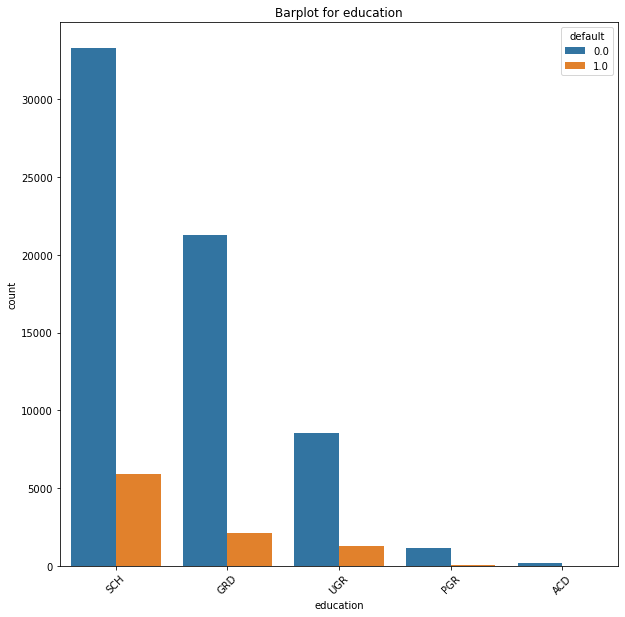

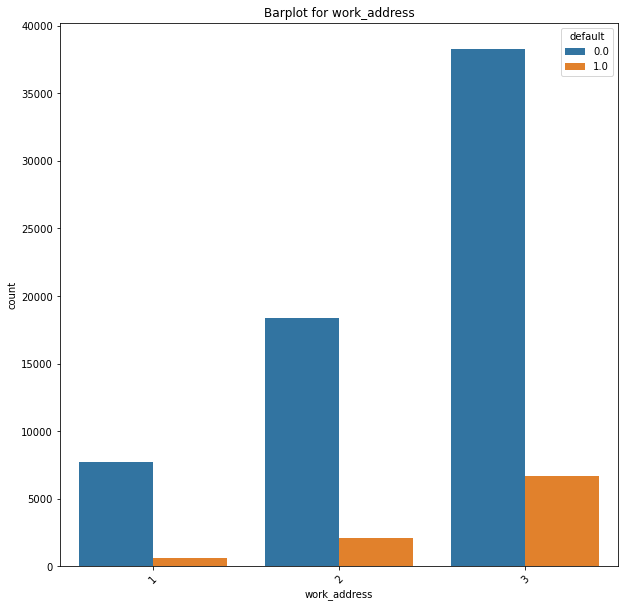

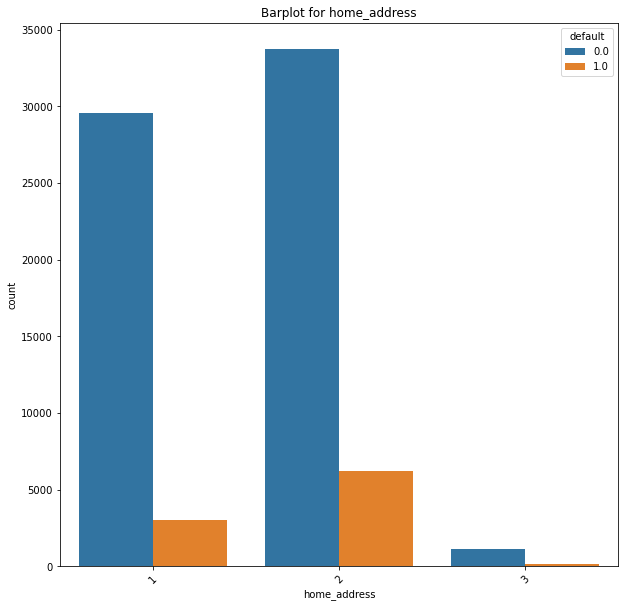

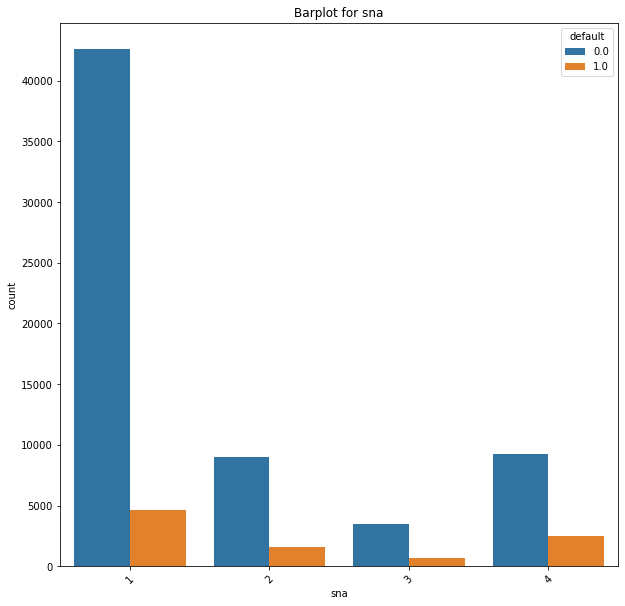

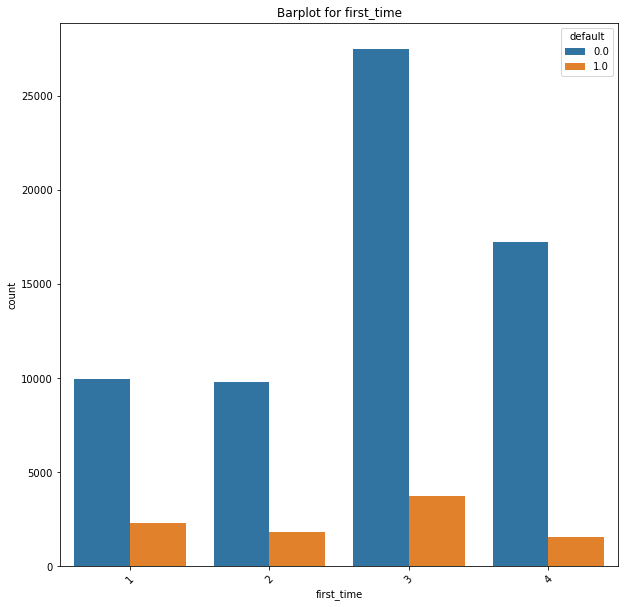

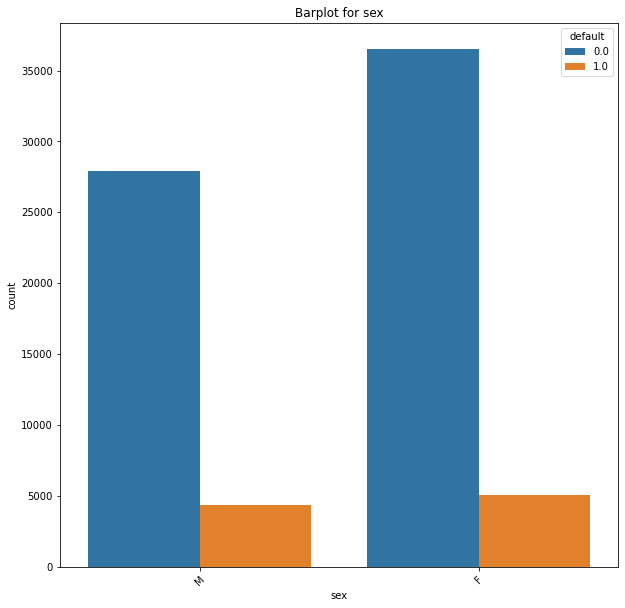

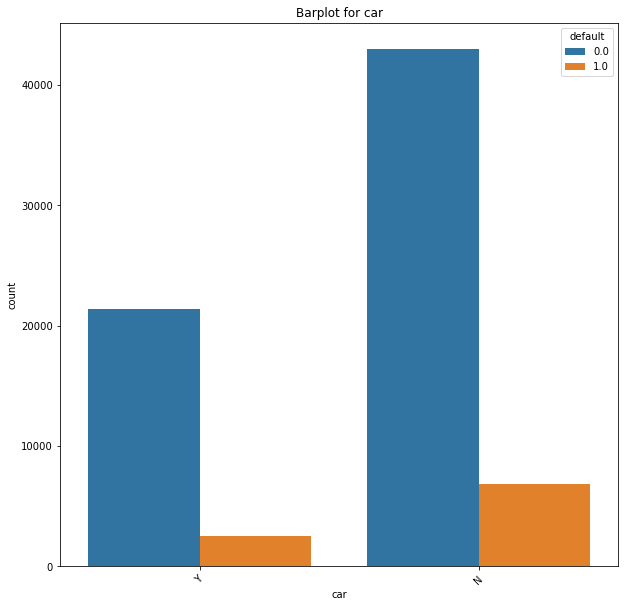

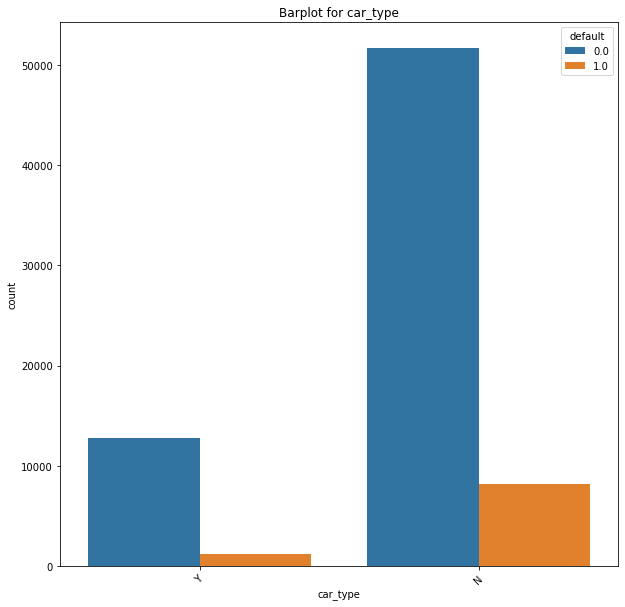

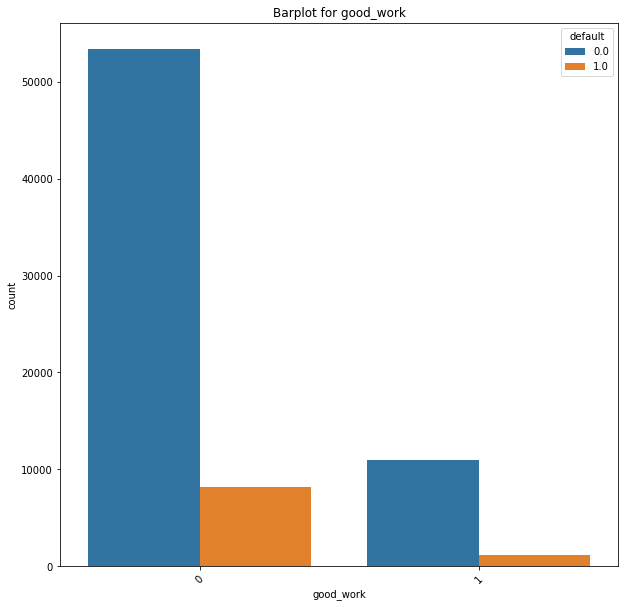

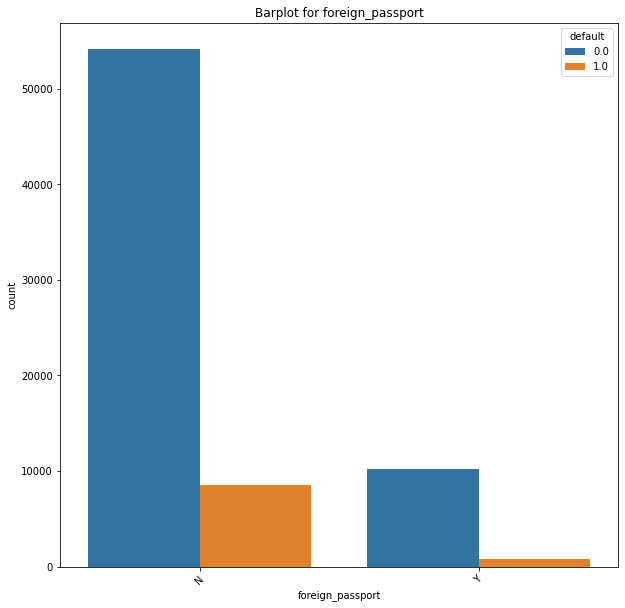

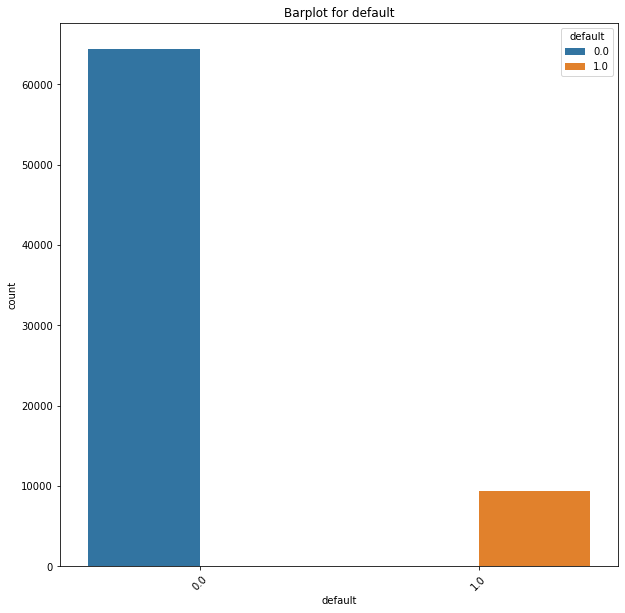

In [10]:
for column in all_categories:
    category_barplot(column)

#### 1. Education
From the disctribution it is clear that 

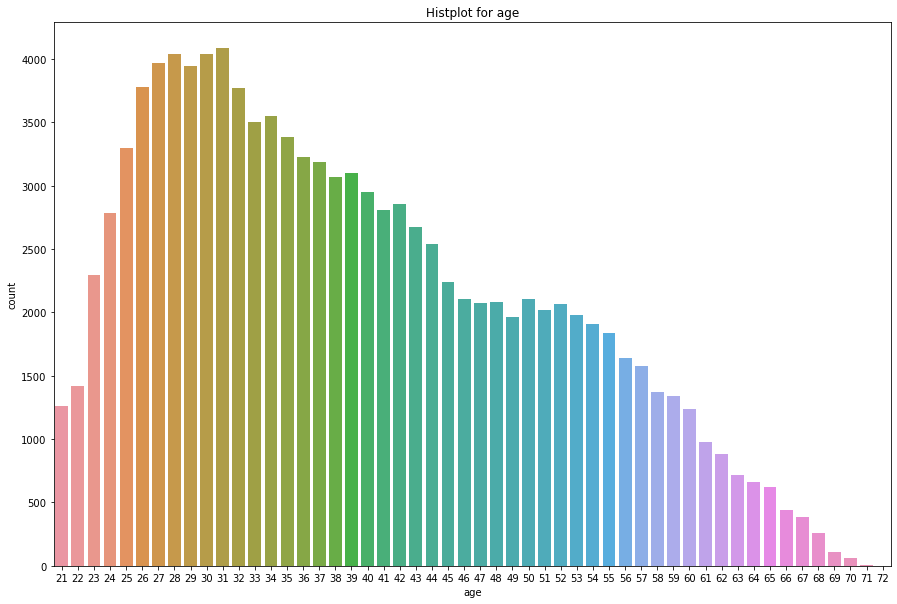

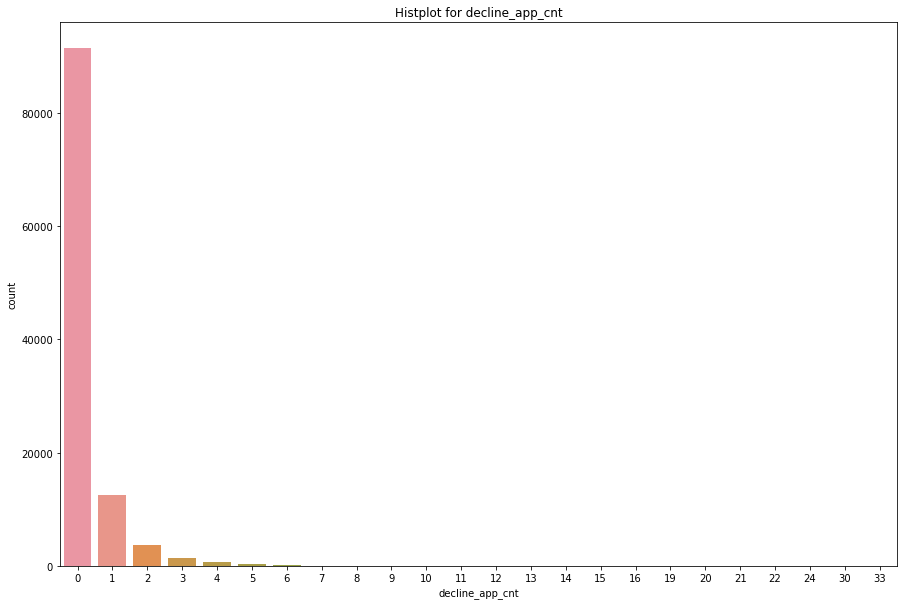

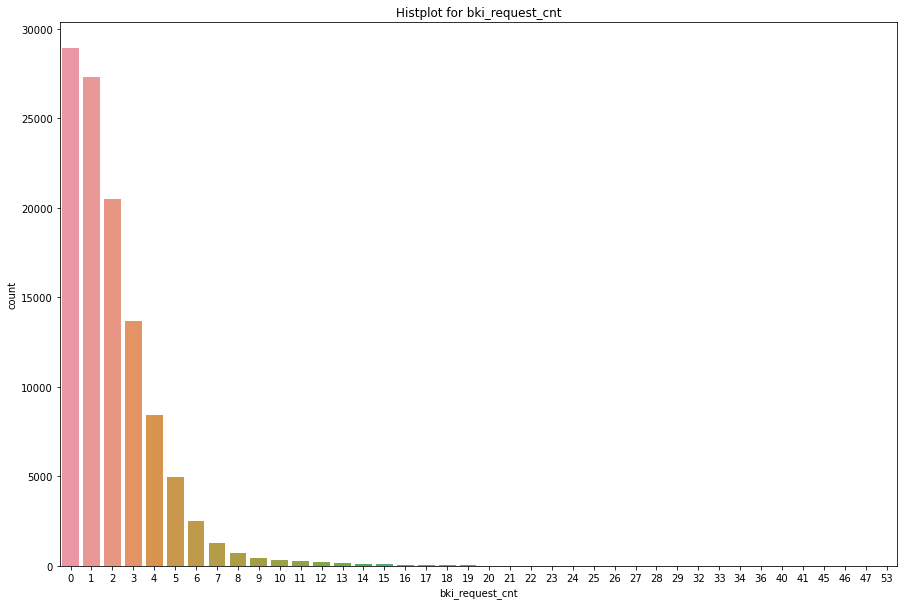

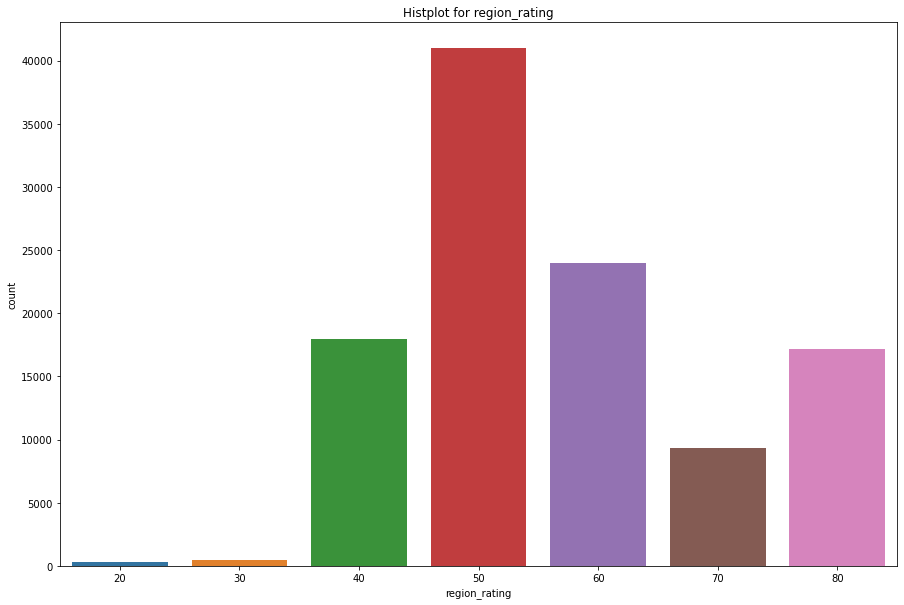

In [11]:
for column in numerical[:-3]+['region_rating']:
    # Due to income having a much bigger variety of
    # values it needs to be plotted separatly
    numerical_histplot(column)

The distribution of most numerical values is shifted to the left. To normalise the data, a log of numerical values will be taken:

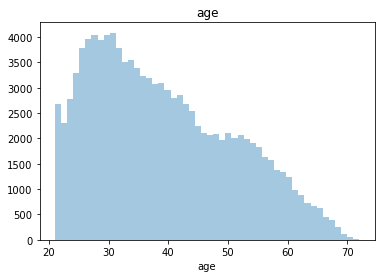

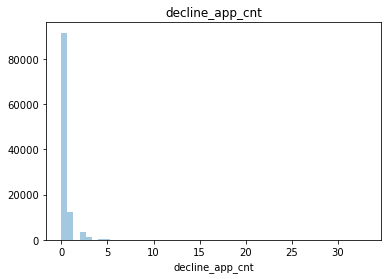

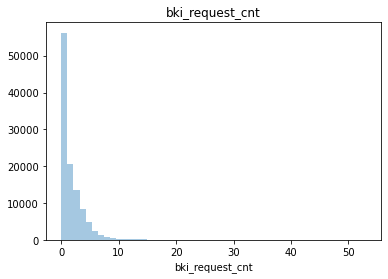

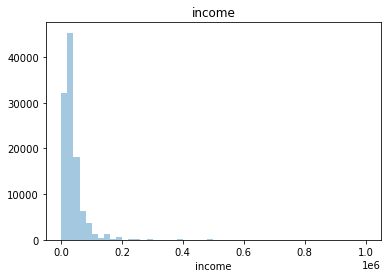

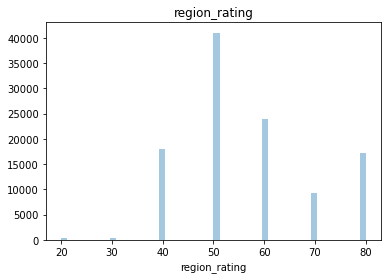

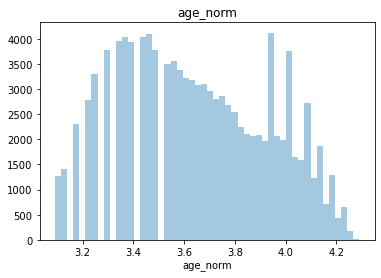

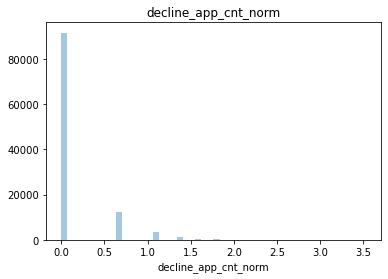

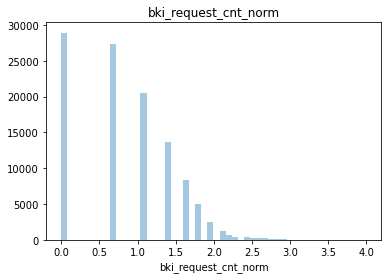

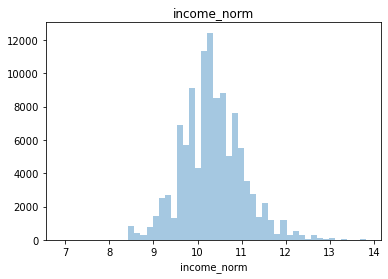

In [12]:
numerical_norm = []
for column in numerical[:-2]:
    # normalising age and income by taking log values
    column_norm = column+'_norm'
    numerical_norm.append(column_norm)
    df[column_norm] = df[column].apply(lambda x: np.log(x+1))

    
for column in numerical[:-1] + numerical_norm:
    # both initial and normalise data is plotted for
    # comparison
    normalised_histplot(column)

numerical_norm += ['score_bki', 'region_rating']

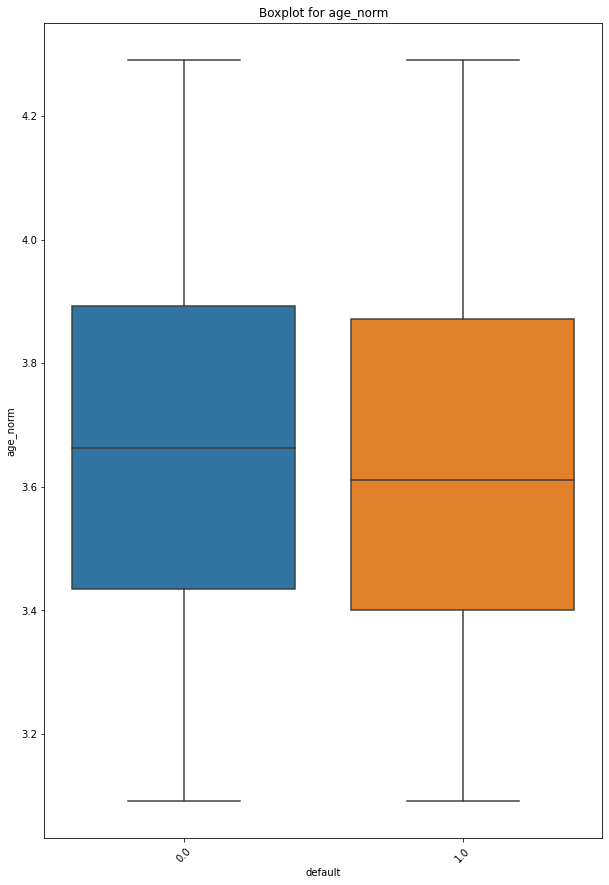

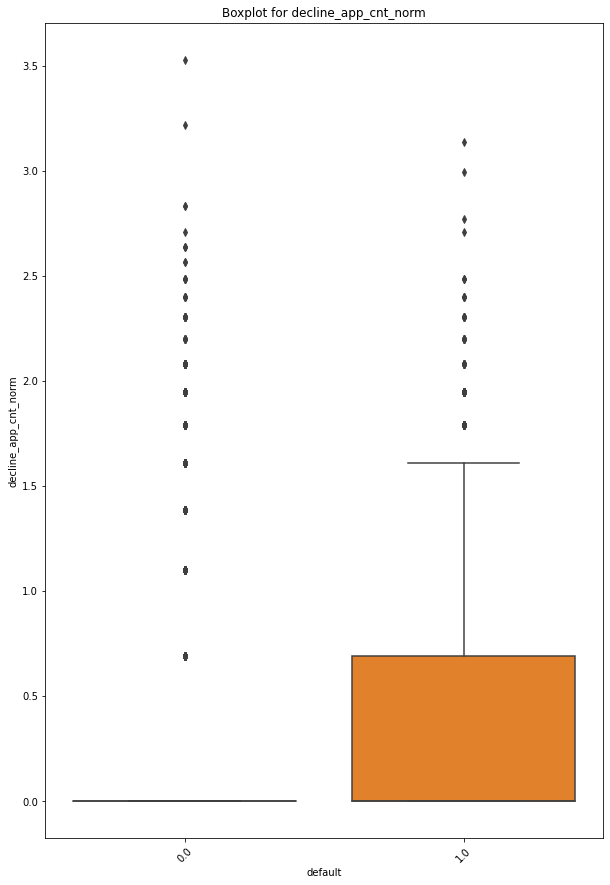

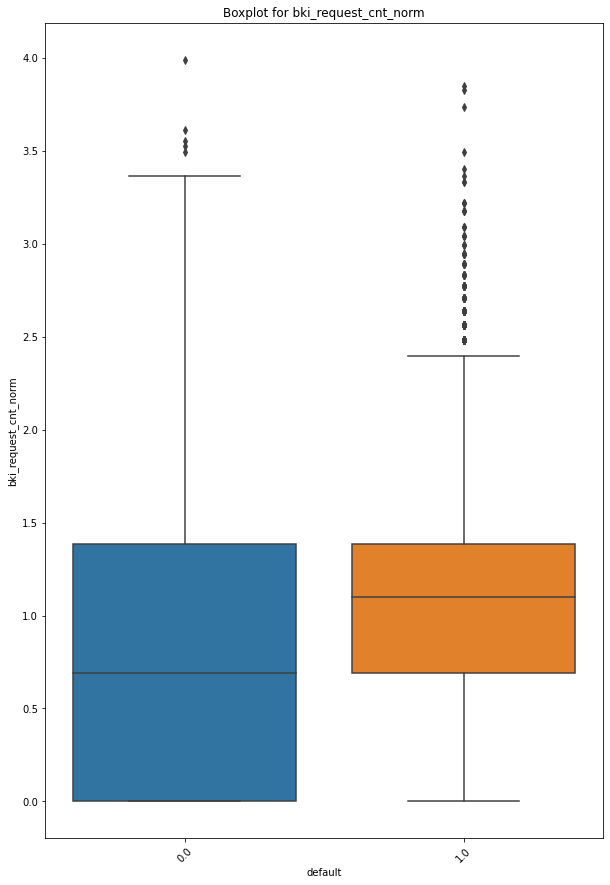

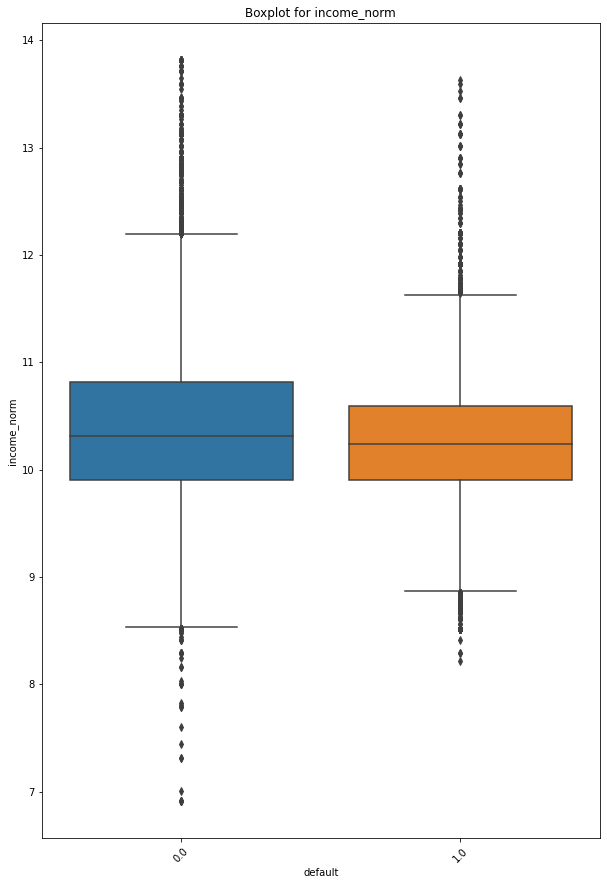

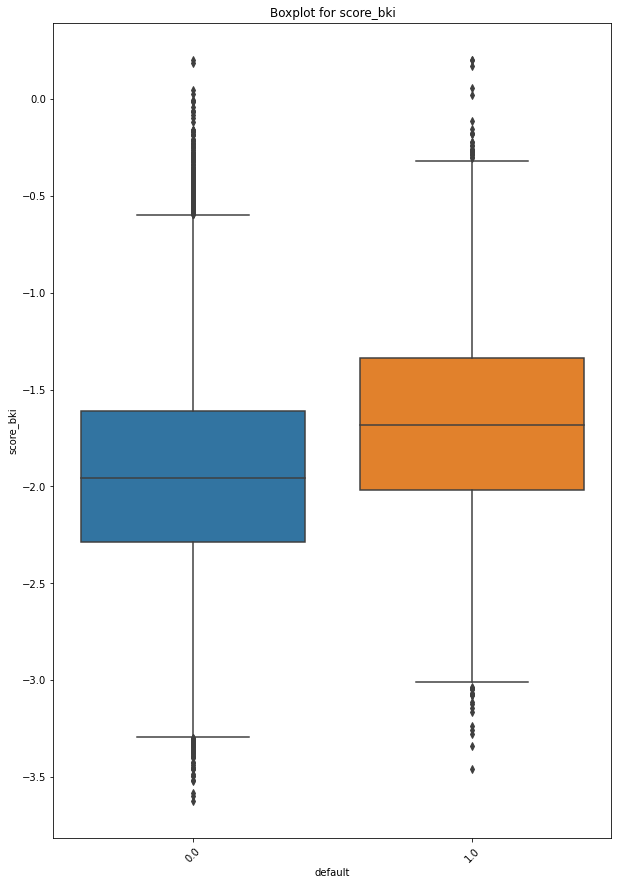

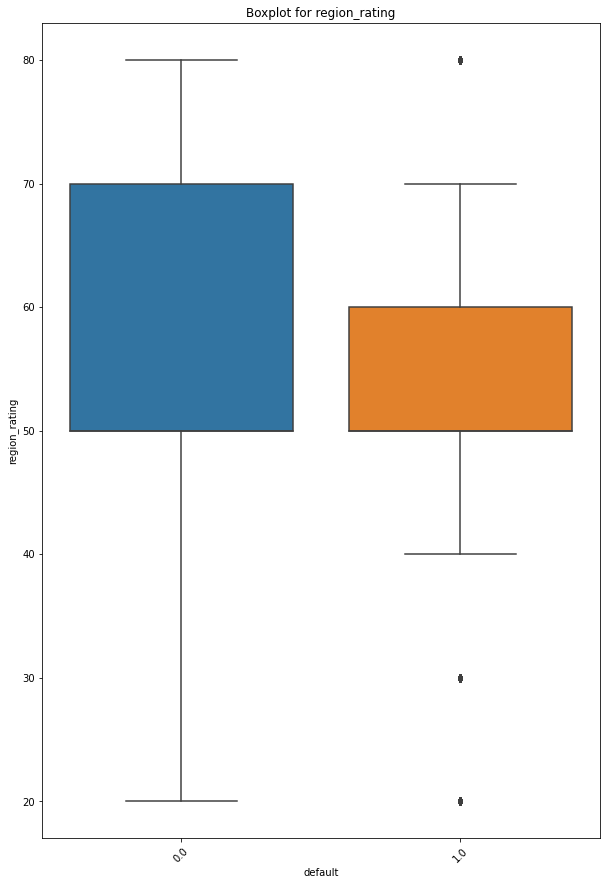

In [14]:
for column in numerical_norm:
    boxplot_numerical(column)

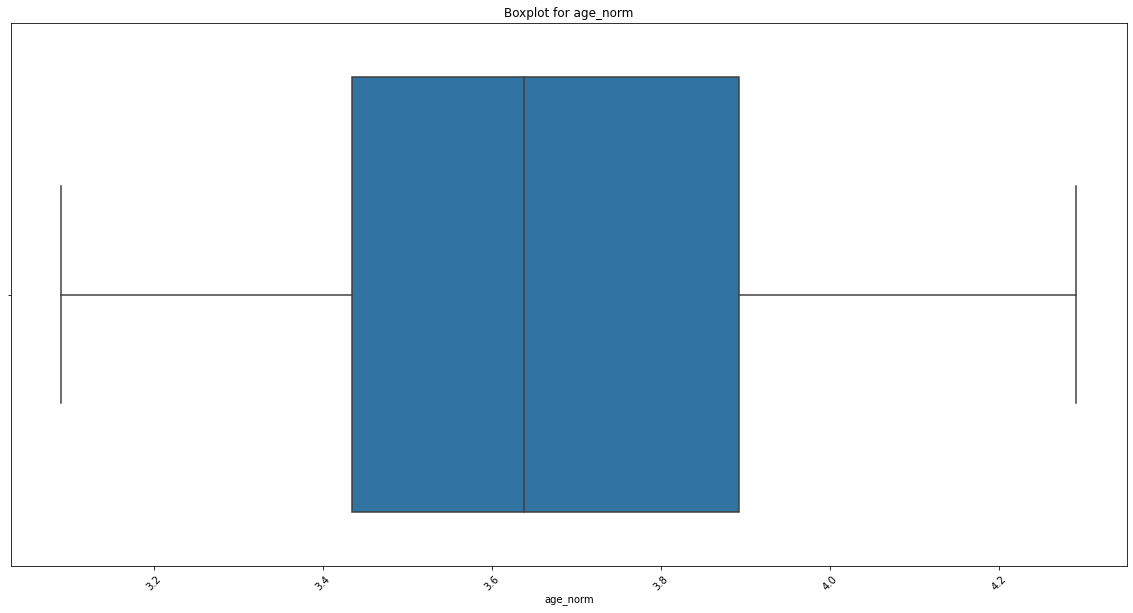

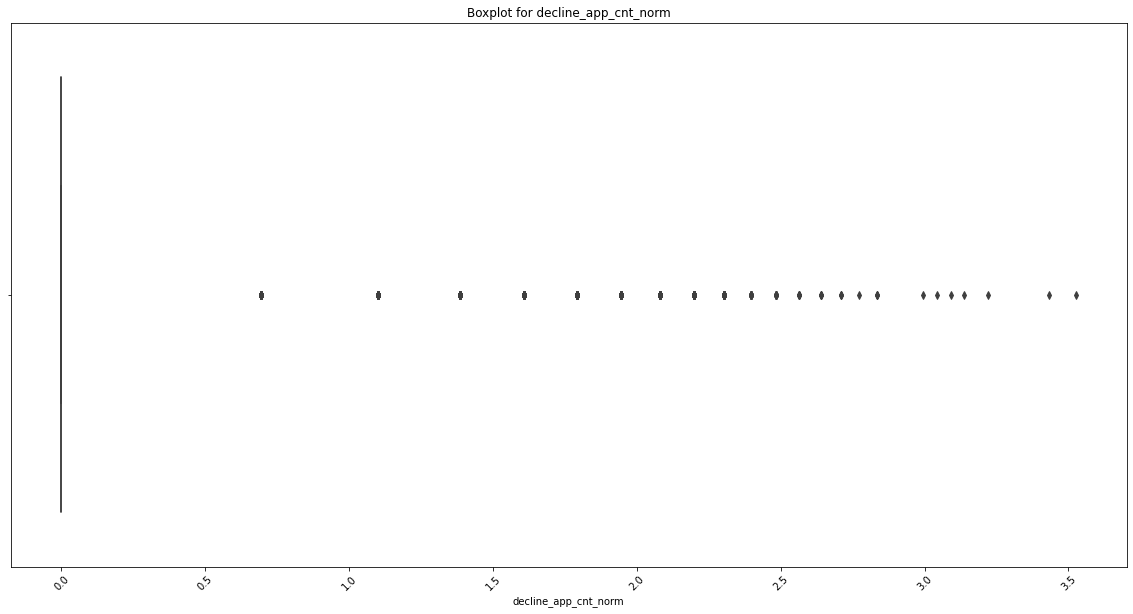

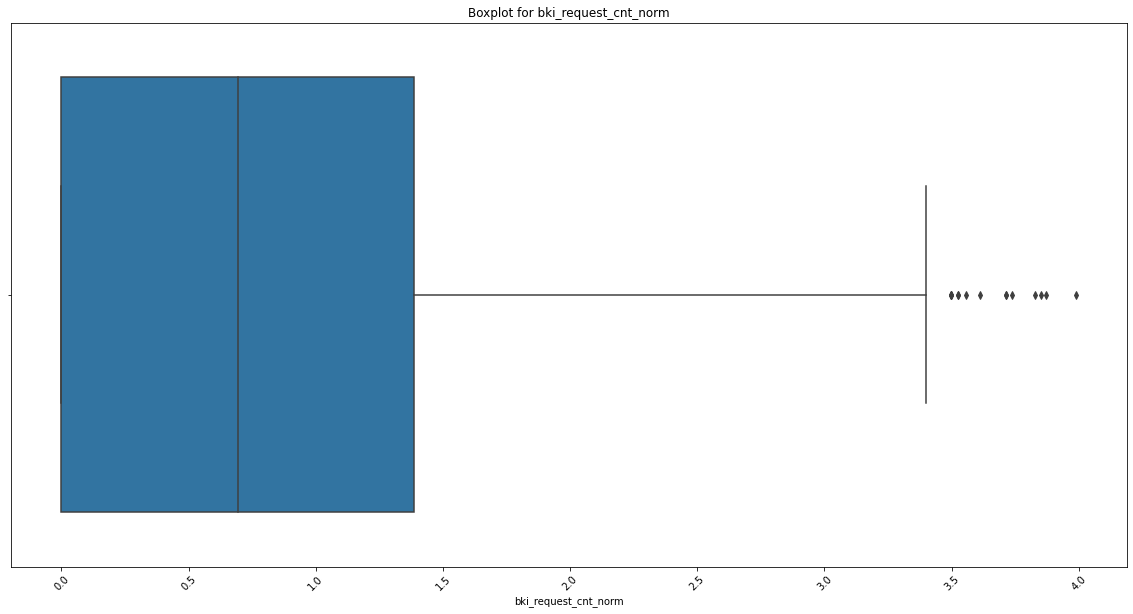

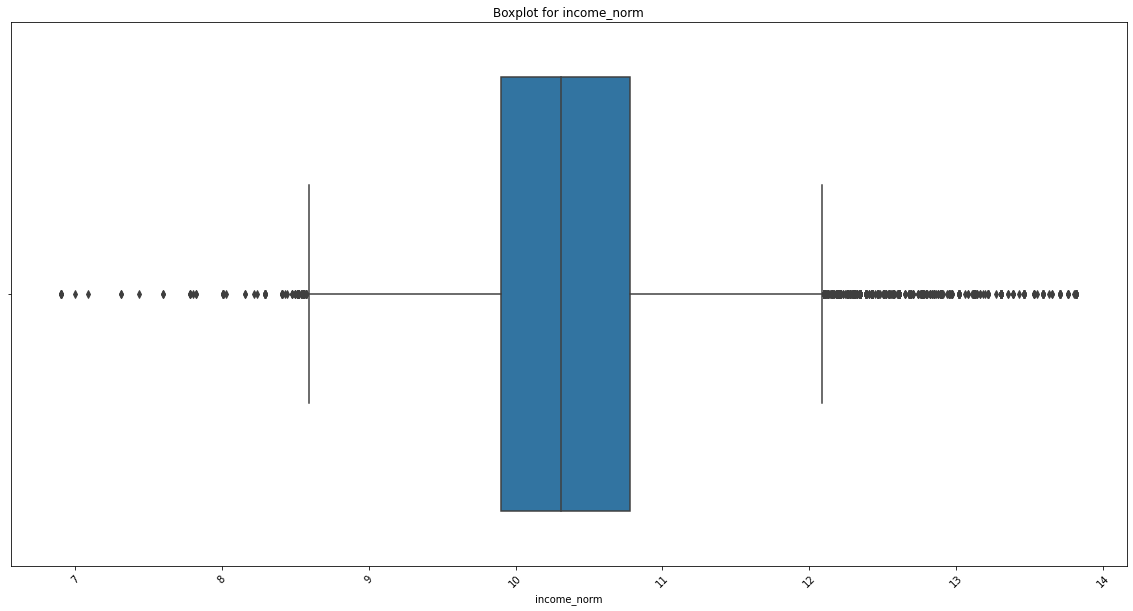

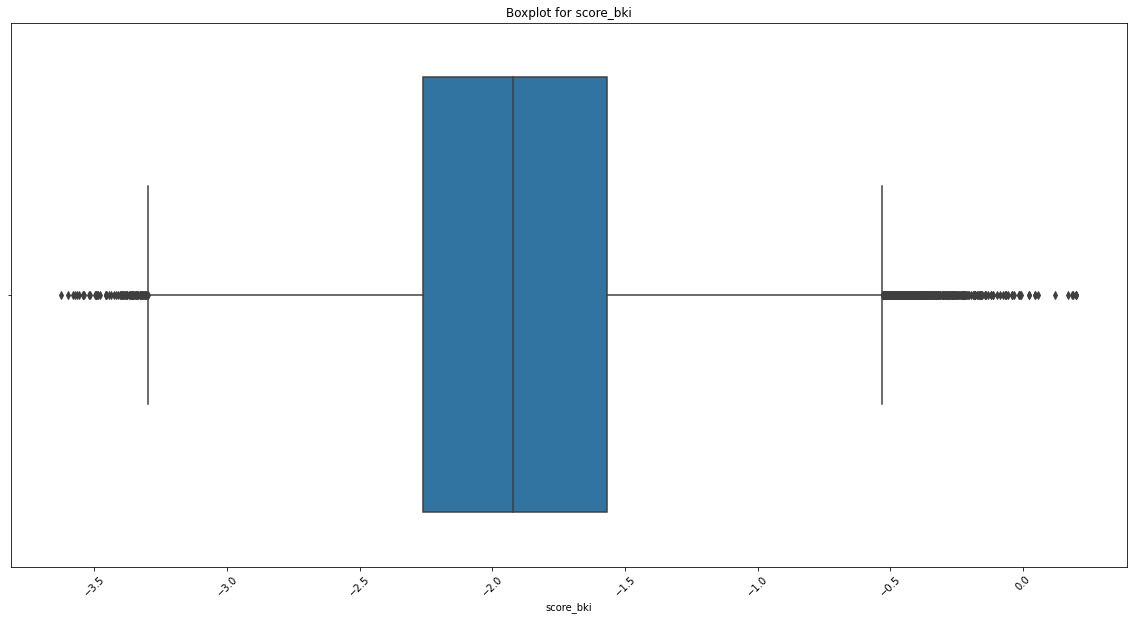

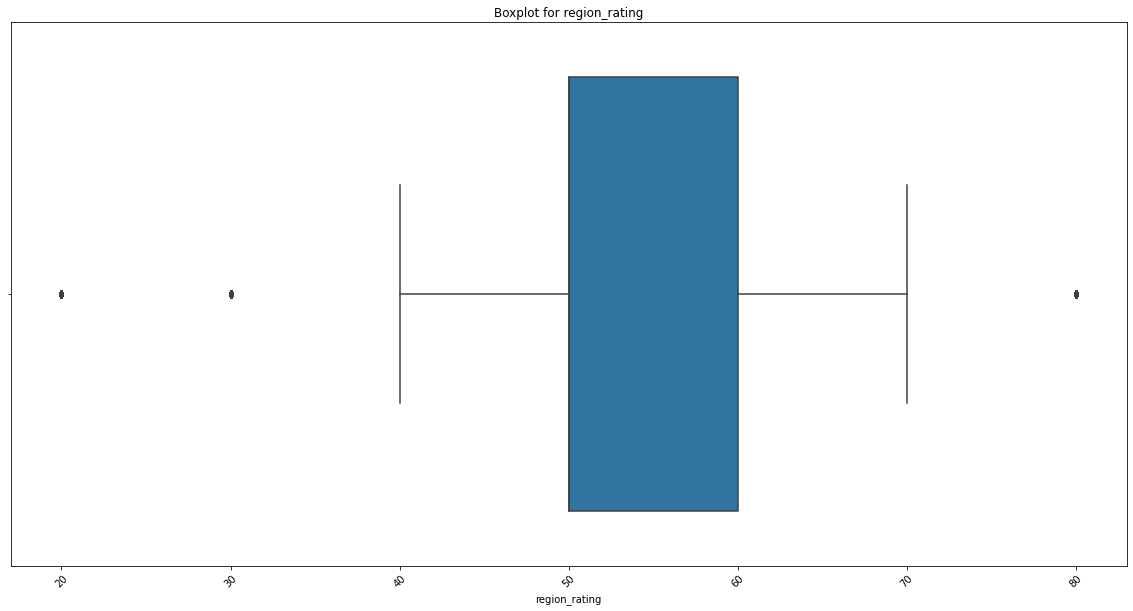

In [15]:
for column in numerical_norm:
    clear_boxplot(column)

In [16]:
outliers = ['age_norm', 'bki_request_cnt_norm',
            'income_norm', 'score_bki',
            'region_rating']

## 1.5 app_date

In [17]:
df['app_date'] = pd.to_datetime(df['app_date'])

In [18]:
df['month'] = df['app_date'].apply(lambda x: x.month)
df['weekend']= df['app_date'].apply(if_weekend)
binary += ['weekend']
category += ['month']

# 2. Preparing data for the model
Cheching the correlations, preparing dummies and changing format of the categorical values.

## 2.1 Numerical preparations
Building a correlations heatmap, checking which numerical column afffects the target value the most

In [19]:
df[numerical_norm].corr().abs()

,age_norm,decline_app_cnt_norm,bki_request_cnt_norm,income_norm,score_bki,region_rating
age_norm,1.000000,0.128624,0.050241,0.090734,0.109169,0.090629
decline_app_cnt_norm,0.128624,1.000000,0.127531,0.013959,0.207342,0.042188
bki_request_cnt_norm,0.050241,0.127531,1.000000,0.078649,0.141600,0.015935
income_norm,0.090734,0.013959,0.078649,1.000000,0.002592,0.313187
score_bki,0.109169,0.207342,0.141600,0.002592,1.000000,0.007132
region_rating,0.090629,0.042188,0.015935,0.313187,0.007132,1.000000


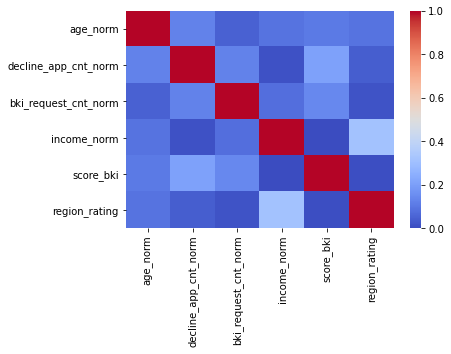

In [20]:
sns.heatmap(df[numerical_norm].corr().abs(),
            vmin=0,
            vmax=1,
            cmap='coolwarm')

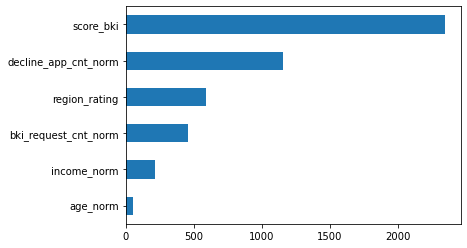

In [21]:
imp_num = pd.Series(
    f_classif(df[df['building_model']==1][numerical_norm],
              df[df['building_model']==1]['default'])[0],
    index = numerical_norm)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

## 2.2 Categorical data

In [22]:
label_encoder = LabelEncoder()
# example of use of LabelEncoder
mapped_education = pd.Series(label_encoder.fit_transform(df['sex']))
print(dict(enumerate(label_encoder.classes_)))

{0: 'F', 1: 'M'}


In [23]:
#Applying LabelEncodder on all binary values
for column in binary:
    df[column] = label_encoder.fit_transform(df[column])

df[binary].head()

,sex,car,car_type,good_work,foreign_passport,weekend
0,1,1,1,0,0,1
1,0,0,0,0,0,0
2,1,1,0,0,1,1
3,0,0,0,0,0,0
4,1,0,0,1,1,0


In [24]:
df.education = df.education.apply(lambda x: 4 if x=='ACD' else x)
df.education = df.education.apply(lambda x: 3 if x=='PGR' else x)
df.education = df.education.apply(lambda x: 1 if x=='UGR' else x)
df.education = df.education.apply(lambda x: 2 if x=='GRD' else x)
df.education = df.education.apply(lambda x: 0 if x=='SCH' else x)

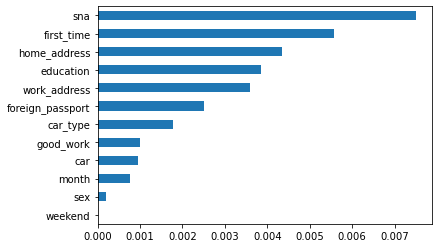

In [25]:
imp_cat = Series(mutual_info_classif(
    df[df['building_model']==1][binary + category],
    df[df['building_model']==1]['default'],discrete_features=True),
                 index = binary + category)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# 3. Model

In [26]:
data = df[df['building_model']==1]

In [27]:
data

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,first_time,foreign_passport,default,building_model,age_norm,decline_app_cnt_norm,bki_request_cnt_norm,income_norm,month,weekend
0,25905,2014-02-01,0,1,62,1,1,0,0,-2.008753,...,1,0,0.0,1,4.143135,0.000000,0.693147,9.798183,2,1
1,63161,2014-03-12,0,0,59,0,0,0,0,-1.532276,...,1,0,0.0,1,4.094345,0.000000,1.386294,9.852247,3,0
2,25887,2014-02-01,0,1,25,1,0,2,0,-1.408142,...,4,1,0.0,1,3.258097,1.098612,0.693147,10.308986,2,1
3,16222,2014-01-23,0,0,53,0,0,0,0,-2.057471,...,3,0,0.0,1,3.988984,0.000000,1.098612,9.210440,1,0
4,101655,2014-04-18,2,1,48,0,0,0,1,-1.244723,...,4,1,0.0,1,3.891820,0.000000,0.693147,10.308986,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73794,54887,2014-03-04,2,0,45,0,0,0,0,-1.792064,...,4,0,0.0,1,3.828641,0.000000,1.386294,9.741027,3,0
73795,76821,2014-03-24,0,1,41,1,1,0,0,-2.058029,...,4,0,0.0,1,3.737670,0.000000,0.693147,11.156265,3,0
73796,103695,2014-04-22,0,1,31,0,0,0,0,-1.512635,...,2,0,0.0,1,3.465736,0.000000,1.609438,10.714440,4,0
73797,861,2014-01-04,0,0,29,0,0,0,1,-1.479334,...,3,0,1.0,1,3.401197,0.000000,1.386294,9.472782,1,1


In [28]:
# X_numerical = StandardScaler().fit_transform(
#   df[df['building_model']==1][numerical_norm].values
# )

# X_category = OneHotEncoder(sparse = False).fit_transform(
#    df[df['building_model']==1][category].values
# )

X_numerical = StandardScaler().fit_transform(
    data[numerical_norm].values
)

X_category = OneHotEncoder(sparse = False).fit_transform(
    data[category].values
)



In [29]:
X = np.hstack([X_numerical,
               data[binary].values,
               X_category])
Y = data['default'].values

## 3.1a Logical Regression with no set hyperparameters

In [30]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)
log_reg_simpl = LogisticRegression()
log_reg_simpl.fit(X_train, y_train)

LogisticRegression()

In [31]:
probs = log_reg_simpl.predict_proba(X_val)
probs = probs[:,1]
y_pred = log_reg_simpl.predict(X_val)

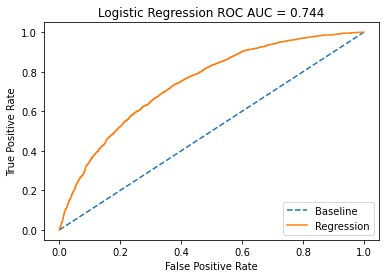

accuracy_score: 0.8748644986449865
precision_score: 0.4074074074074074
recall_score: 0.0240831964969896
f1_score: 0.0454780361757106


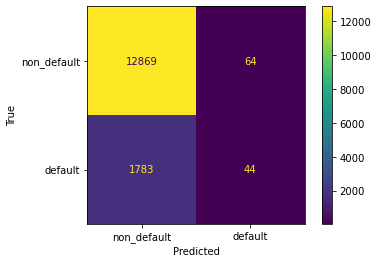

In [32]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val, y_pred)

The model appears to favour non_default over default very heavily, accuracy is fairly high, yet all the other metrics are abyssmal. The issue needs to be adrressed, so oversampling and undersampling will take place, as well as class_weight will be set to "balanced".

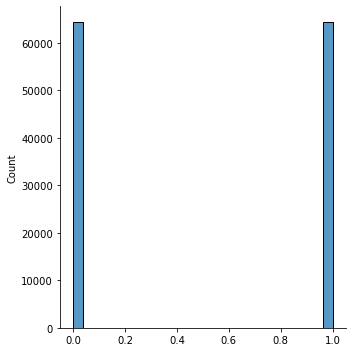

In [33]:
oversample = RandomOverSampler(sampling_strategy = 'minority')
X_over, Y_over = oversample.fit_resample(X, Y)
sns.displot(Y_over)

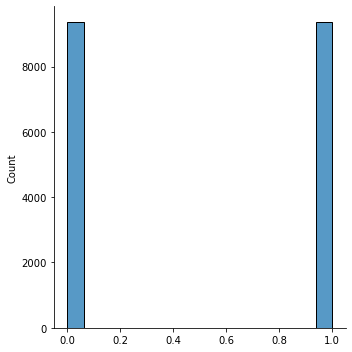

In [34]:
undersample = RandomUnderSampler(sampling_strategy = 'majority')
X_under, Y_under = undersample.fit_resample(X, Y)
sns.displot(Y_under)

## 3.1c Logical Regression with oversampling and undersampling

In [35]:
# Undersampling takes place parallel to oversampling to compare the two models
# Oversampled model
X_train_o, X_val_o, y_train_o, y_val_o = train_test_split(X_over,
                                                          Y_over,
                                                          test_size=0.20,
                                                          random_state=42)
log_reg_over = LogisticRegression(class_weight='balanced')
log_reg_over.fit(X_train_o, y_train_o)

# undersampled model
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_under,
                                                          Y_under,
                                                          test_size=0.20,
                                                          random_state=42)
log_reg_under = LogisticRegression(class_weight='balanced')
log_reg_under.fit(X_train_u, y_train_u)

LogisticRegression(class_weight='balanced')

In [36]:
# Oversampled predictions
probs_o = log_reg_over.predict_proba(X_val_o)
probs_o = probs_o[:,1]
y_pred_o = log_reg_over.predict(X_val_o)

# Undersampled predictions
probs_u = log_reg_under.predict_proba(X_val_u)
probs_u = probs_u[:,1]
y_pred_u = log_reg_under.predict(X_val_u)

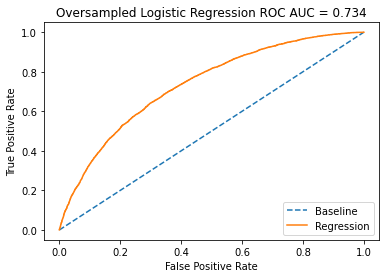

accuracy_score: 0.6694346358309728
precision_score: 0.6704058580665264
recall_score: 0.6674422211881496
f1_score: 0.6689207570634643


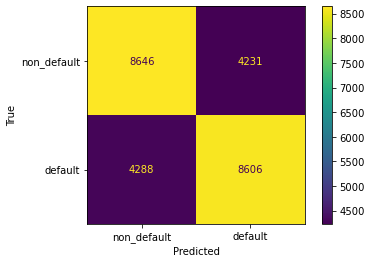

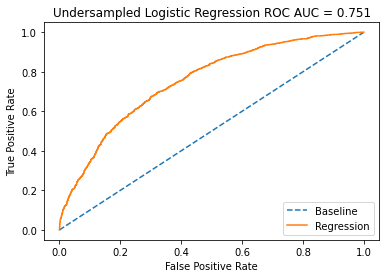

accuracy_score: 0.6849826620432116
precision_score: 0.6806366047745358
recall_score: 0.6890440386680988
f1_score: 0.6848145182812918


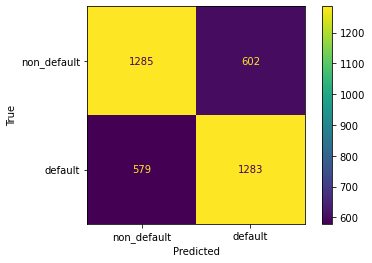

In [37]:
fpr, tpr, threshold = roc_curve(y_val_o, probs_o)
roc_auc = roc_auc_score(y_val_o, probs_o)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Oversampled Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val_o, y_pred_o)


fpr, tpr, threshold = roc_curve(y_val_u, probs_u)
roc_auc = roc_auc_score(y_val_u, probs_u)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Undersampled Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val_u, y_pred_u)

## 3.2a KNeighborsClassifier Simple

In [38]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.20, random_state=42)
kneigh_simple = KNeighborsClassifier(n_neighbors=5)
kneigh_simple.fit(X_train, y_train)

KNeighborsClassifier()

In [39]:
probs = kneigh_simple.predict_proba(X_val)
probs = probs[:,1]
y_pred = kneigh_simple.predict(X_val)

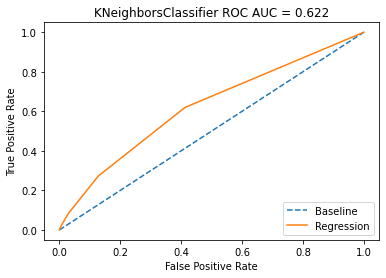

accuracy_score: 0.8602303523035231
precision_score: 0.2838827838827839
recall_score: 0.08483853311439518
f1_score: 0.1306363253265908


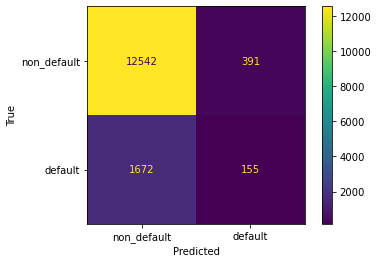

In [40]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('KNeighborsClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val, y_pred)

## 3.2b KNeighborsClassifier undersampling

In [41]:
X_train, X_val, y_train, y_val = train_test_split(X_under,
                                                  Y_under,
                                                  test_size=0.20,
                                                  random_state=42)
kneigh_under = KNeighborsClassifier(n_neighbors=5)
kneigh_under.fit(X_train, y_train)

KNeighborsClassifier()

In [42]:
probs = kneigh_under.predict_proba(X_val)
probs = probs[:,1]
y_pred = kneigh_under.predict(X_val)

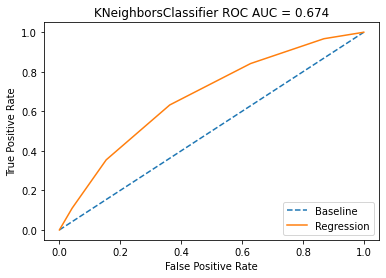

accuracy_score: 0.6348359562550013
precision_score: 0.6324556689951639
recall_score: 0.6321160042964554
f1_score: 0.6322857910287402


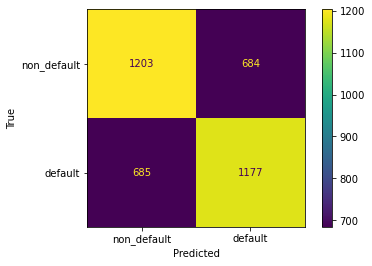

In [43]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('KNeighborsClassifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val, y_pred)

## 3.3 RandomForestClassifier

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_under,
                                                  Y_under,
                                                  test_size=0.20,
                                                  random_state=42)
rfc = RandomForestClassifier(class_weight='balanced')
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [45]:
probs = rfc.predict_proba(X_val)
probs = probs[:,1]
y_pred = rfc.predict(X_val)

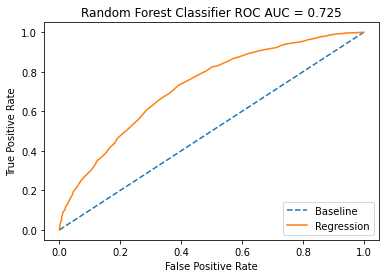

accuracy_score: 0.6652440650840225
precision_score: 0.6591504981646565
recall_score: 0.6750805585392051
f1_score: 0.667020429822234


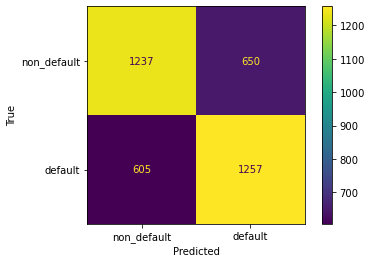

In [46]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Random Forest Classifier ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
metrics(y_val, y_pred)

In [47]:
X_numerical_sub = StandardScaler().fit_transform(
    df[df['building_model']==0][numerical_norm].values
)
X_category_sub = OneHotEncoder(sparse = False).fit_transform(
    df[df['building_model']==0][category].values
)
X_sub = np.hstack([X_numerical_sub,
               df[df['building_model']==0][binary].values,
               X_category_sub])

In [48]:
model = log_reg_under

In [49]:
sub = df[df.default.isna()]
sub['default'] = model.predict(X_sub)

In [50]:
submission = sub[['client_id', 'default']]
submission

,client_id,default
73799,74835,0.0
73800,17527,1.0
73801,75683,0.0
73802,26883,0.0
73803,28862,0.0
...,...,...
110143,83775,1.0
110144,106254,0.0
110145,81852,1.0
110146,1971,1.0


In [51]:
submission.to_csv('submission.csv', index=False)